# Identification of design margins in the design of a strut

## Defining the components of the margin analysis network

The components of the margin analysis network are:

* Input parameters
    * Design parameters
    * Fixed parameters
    * Input specifications
* Intermediate parameters
* Decision nodes
* Output parameters
    * Performance parameters
    * Target thresholds
    * Decided values

### Design parameters

<figure>
  <center><p><img src="../images/strut_example/strut_overview.png"
    width="950pt" align="middle">
  <figcaption>Fig.1 Schematic of strut design example</figcaption>
</figure>

This example shows how to evaluate the design margins of a strut which is a part of the turbine rear frame of an aeroengine. In this example, we consider three design parameters of the strut the lean angle $\theta$, the vane width $w$, and the vane height $h$

In [1]:
from mvm import DesignParam

# define design parameters
d1 = DesignParam(100.0, 'D1', universe=(70.0, 130.0), variable_type='FLOAT', description='vane length', symbol='w')
d2 = DesignParam(15.0, 'D2', universe=(5.0, 20.0), variable_type='FLOAT', description='vane height', symbol='h')
d3 = DesignParam(10.0, 'D3', universe=(0.0, 30.0), variable_type='FLOAT', description='lean angle', symbol='theta')
design_params = [d1,d2,d3]

### Fixed parameters

We also specify some constants for this example, such as elastic modulus $E$, coefficient of thermal expansion $\alpha$, hub and shroud radii, $r_1$ and $r_2$, respectively, and ambient temperature $T_\mathrm{sink}$

In [2]:
from mvm import FixedParam

# define fixed parameters
i1 = FixedParam(7.17E-06, 'I1', description='Coefficient of thermal expansion', symbol='alpha')
i2 = FixedParam(156.3E3, 'I2', description='Youngs modulus', symbol='E')
i3 = FixedParam(346.5, 'I3', description='Radius of the hub', symbol='r1')
i4 = FixedParam(536.5, 'I4', description='Radius of the shroud', symbol='r2')
i5 = FixedParam(25.0, 'I6', description='ambient temperature', symbol='T_sink')

fixed_params = [i1, i2, i3, i4, i5]

### Input specifications

The strut experiences a compressive force $F$ and bending moment $M$ as a result of non-uniform expansion of the turbine rear frame during operation. This is attributed to two temperatures $T_1$ and $T_2$ that occur at the shroud and hub surfaces, respectively as shown below:

<figure>
  <center><p><img src="../images/strut_example/simplified_strut_model.png"
    width="250pt" align="middle">
  <figcaption>Fig.2 Temperature loads</figcaption>
</figure>

The temperatures $T_1$ and $T_2$ are defined as input specifications. The argument ``inc`` specifies the expected direction of change of these temperatures during operation and will be used later on to compute the ability of a design margin to absorb change of said temperatures

* $T_1$ is expected to decrease by 1\% of the nominal value
* $T_2$ is expected to increase by 1\% of the nominal value

If the absolute change is to be specified, then change the argument ``inc_type`` to ``'abs'``

In [3]:
from mvm import InputSpec

# define input specifications
s1 = InputSpec(450, 'S1', universe=[325, 550], variable_type='FLOAT', description='nacelle temperature',
               symbol='T1', inc=-1e-0, inc_type='rel')
s2 = InputSpec(425, 'S2', universe=[325, 550], variable_type='FLOAT', description='gas surface temperature',
               symbol='T2', inc=+1e-0, inc_type='rel')
input_specs = [s1, s2]

### Performance parameters

we then calculate weight and cost as:

$$
W = \rho whL\\
\mathrm{cost} = c\rho whL,
$$

where $c$ is the raw material cost per unit weight. and $L$ is the length of the strut given by $L = -r_1\cos{\theta} + \sqrt{{r_2}^2 - {r_1}^2\sin^2{\theta}}$

$W$ and $\mathrm{cost}$ are *performance parameters*. Their calculation is given by a *behaviour* model ``b1``

In [4]:
from mvm import Behaviour
import numpy as np

# this is the weight and cost model
class B1(Behaviour):
    def __call__(self, rho, w, h, theta, r1, r2, cost_coeff):
        L = -r1 * np.cos(np.deg2rad(theta)) + np.sqrt(r2 ** 2 - (r1 * np.sin(np.deg2rad(theta))) ** 2)
        weight = rho * w * h * L
        cost = weight * cost_coeff
        self.performance = [weight, cost]

b1 = B1(n_i=0, n_p=2, n_dv=0, n_tt=0, key='B1')

We specify whether increasing this parameter is beneficial or detrimental to the design's performance using the ``direction`` argument

In [5]:
from mvm import Performance
# Define performances
p1 = Performance('P1', direction='less_is_better')
p2 = Performance('P2', direction='less_is_better')
performances = [p1, p2]

### Target thresholds

The strut must support the forces shown perviously on Figure 2:

* A compressive stress $\sigma_a$ due to the force $F$
* A bending stress $\sigma_m$ due to the bending moment $M$

$$
\sigma_a = \dfrac{E\alpha}{L}\left(T_2r_2 - T_1r_1 - T_\text{sink}(r_2-r_1)\right)\cos{\theta}\\
\sigma_m =\dfrac{3}{2}\dfrac{Eh\alpha}{L^2}\left(T_2r_2 - T_1r_1 - T_\text{sink}(r_2-r_1)\right)\sin{\theta}
$$

The maximum stress value becomes the *target threshold*.


$$
\sigma_\mathrm{max} = \max{\left(\sigma_a,\sigma_m\right)}
$$

This is defined by *behaviour* model ``b2``

In [6]:
# this is the stress model
class B2(Behaviour):
    def __call__(self, T1, T2, h, theta, alpha, E, r1, r2, T_sink):
        L = -r1 * np.cos(np.deg2rad(theta)) + np.sqrt(r2 ** 2 - (r1 * np.sin(np.deg2rad(theta))) ** 2)
        sigma_a = (E * alpha) * ((T2 * r2) - (T1 * r1) - (T_sink * (r2 - r1))) * np.cos(np.deg2rad(theta)) / L
        sigma_m = (3 / 2) * ((E * h) / (L ** 2)) * (
                alpha * ((T2 * r2) - (T1 * r1) - (T_sink * (r2 - r1))) * np.sin(np.deg2rad(theta)))
        self.threshold = max([sigma_a, sigma_m])

b2 = B2(n_i=0, n_p=0, n_dv=0, n_tt=1, key='B2')

### Decided values (from Decision nodes)

After calculating the target thresholds (what the design needs to do) we have to make decisions regarding certain 'off-the-shelf' components. The decided value in this case is given by the yield stress of the selected material. We define a decision node using the ``Design`` class and a corresponding ``Behaviour`` model to translate the selected material to a decided value. The material model also supplies two additional intermediate parameters that are required by the cost model in ``b1``. They are the density $\rho$ and the cost density $c$

In [7]:
from mvm import Decision

class B3(Behaviour):
    def __call__(self, material):
        material_dict = {
            'dummy'   : {
                'sigma_y' : 92, # MPa
                'rho' : 11.95e-06, # kg/mm3
                'cost' : 0.1 # USD/kg
            },
            'Steel'   : {
                'sigma_y' : 250, # MPa
                'rho' : 10.34e-06, # kg/mm3
                'cost' : 0.09478261, # USD/kg
                },
            'Inconel'  : {
                'sigma_y' : 460,  # MPa
                'rho' : 8.19e-06,  # kg/mm3
                'cost' : 0.46,  # USD/kg
                },
            'Titanium'  : {
                'sigma_y' : 828, # MPa
                'rho' : 4.43e-06, # kg/mm3
                'cost' : 1.10 # USD/kg
                },
        }
        chosen_mat = material_dict[material]

        self.intermediate = [chosen_mat['rho'], chosen_mat['cost']]
        self.decided_value = chosen_mat['sigma_y']

        return self.decided_value

b3 = B3(n_i=2, n_p=0, n_dv=1, n_tt=0, key='B3')

# Define decision nodes and a model to convert to decided values
decision_1 = Decision(universe=['Steel', 'Inconel', 'Titanium'], variable_type='ENUM', key='decision_1',
                      direction='must_not_exceed', decided_value_model=b3, description='The type of material')

decisions = [decision_1, ]

We concatenate all behaviour models into a list

In [8]:
behaviours = [b1,b2,b3]

### Excess margins

The design must support the following loads

* A maximum stress **less than** the yield stress $\sigma_y$

We have one design margin given by:

$$
e_1 = \sigma_y - \sigma_\mathrm{max}\\
$$

It is of the ``must_not_exceed`` type

In [9]:
from mvm import MarginNode

# Define margin nodes
e1 = MarginNode('E1', direction='must_not_exceed')
margin_nodes = [e1,]

## Calculation of the value of excess margins in the strut

### Constructing the margin analysis network

We combine all the perviously defined parameters and behaviour models inside a ``MarginNetwork`` object. The ``forward`` method represents a single calculation pass of the margin analysis network

The ``randomize`` method is optional and is used to randomly seed any probabilistic input specifications or behaviour models (see example in next section). The ``MAN`` object below mimics the MAN shown in the figure below:

<figure>
  <center><p><img src="../images/strut_example/MAN.png"
    width="950pt" align="middle">
  <figcaption>Fig.3 Margin analysis network of the strut example</figcaption>
</figure>

In [10]:
from mvm import MarginNetwork

# Define the MAN
class MAN(MarginNetwork):

    def randomize(self):
        pass

    def forward(self, num_threads=1, recalculate_decisions=False, allocate_margin=False, strategy=['min_excess',], outputs=['dv',]):
        # retrieve MAN components
        w = self.design_params[0].value  # w
        h = self.design_params[1].value  # h
        theta = self.design_params[2].value  # theta

        T1 = self.input_specs[0].value  # T1 (could be stochastic)
        T2 = self.input_specs[1].value  # T2 (could be stochastic)

        alpha = self.fixed_params[0].value  # alpha
        E = self.fixed_params[1].value  # E
        r1 = self.fixed_params[2].value  # r1
        r2 = self.fixed_params[3].value  # r2
        T_sink = self.fixed_params[4].value  # T_sink

        b1 = self.behaviours[0]  # calculates weight and cost
        b2 = self.behaviours[1]  # calculates maximum of axial and bending stresses
        b3 = self.behaviours[2]  # calculates material properties

        decision_1 = self.decisions[0]  # select a material based on maximum bending or axial stress

        e1 = self.margin_nodes[0]  # margin against axial or bending failure (sigma_max,sigma_y)

        p1 = self.performances[0]  # weight
        p2 = self.performances[1]  # cost

        # Execute behaviour models

        # T1, T2, h, theta, alpha, E, r1, r2, T_sink
        b2(T1, T2, h, theta, alpha, E, r1, r2, T_sink)
        sigma_max = b2.threshold # the applied load as the target threshold

        # Execute decision node and translation model
        decision_1(sigma_max, recalculate_decisions, allocate_margin, strategy[0], num_threads, outputs[0])
        sigma_prime = decision_1.output_value # this either the target threshold (sigma_max) or the decided value (sigma_y)
        sigma_y = decision_1.decided_value # the yield stress of the chosen material

        # invert decided value: to get rho, and cost_coeff
        b3.inv_call(sigma_prime) 
        rho = b3.intermediate[0]
        cost_coeff = b3.intermediate[1]

        # Compute excesses
        e1(sigma_max, sigma_y)

        # Compute performances
        # rho, w, h, theta, r1, r2, cost_coeff
        b1(rho, w, h, theta, r1, r2, cost_coeff)
        p1(b1.performance[0])
        p2(b1.performance[1])


man = MAN(design_params, input_specs, fixed_params,
          behaviours, decisions, margin_nodes, performances, 'MAN_1')

### Calculating the impact of excess margin on performance

To calculate the level of overdesign w.r.t margin node $m$ and performance parameter $j$ given by

$$
\text{impact}_{mj} = \dfrac{p_j - p^\text{threshold}_{mj}}{p^\text{threshold}_{mj}}
$$

we need to calculate the threshold performance $p^\text{threshold}_{mj}$, i.e., the weight of a hypothetical design where margin node $e_m = 0$, To do so, we construct a surrogate model associated with each behaviour model that is connected to a decision node to allow interpolation of this hypothetical design. In this example it is ``b3`` associated with ``decision_1``.

This allows the MAN's performance parameters $\mathbf{p}$ to be expressed as functions in terms of the margin values $\mathbf{e}$ and input specifications $\mathbf{s}$

$$
\hat{\mathbf{p}} = f(\mathbf{e},\mathbf{s})
$$

we substitute $e_m = 0$ while holding all the other components at their nominal values.

In [11]:
# train material surrogate
variable_dict = {
    'material' : {'type' : 'ENUM', 'limits' : decision_1.universe},
}
b3.train_surrogate(variable_dict,n_samples=50,sm_type='KRG')
b3.train_inverse(sm_type='LS')

___________________________________________________________________________
   
                                    LS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 50
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0009418


/home/khalil/.local/share/virtualenvs/mvmlib-9r_YoSyI/lib/python3.10/site-packages/smt/surrogate_models/krg_based.py:211: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn("Warning: multiple x input features have the same value (at least same row twice).")


We now calculate the impact using ``mvmlib`` using the Kriging surrogate model

$$
\text{impact}_{mj} = \dfrac{p_j - \hat{p}^\text{threshold}_{mj}}{\hat{p}^\text{threshold}_{mj}}
$$

In [12]:
man.reset()
man.init_decisions()
man.allocate_margins()
man.forward()

man.compute_impact()
man.impact_matrix.value

array([[-0.08317867,  0.26427108]])

* The margin node (against yielding) has a positive impact on cost (i.e., its elimination will increase raw material cost). 
* However, the margin node (against yielding) has a negative on weight (i.e., its elimination will reduce weight). 

### Calculation of change absorption capability

We now calculate the ability of the design to absorb deviation in the input specifications from their nominal values. We incrementally increase or decrease each specification $s_i$ until one of the margin nodes is equal to 0. The value of the specification at this point is called $s^\text{max}_i$. The maximum allowable deterioration in the input specification is give by

$$
\text{deterioration}_i = \dfrac{s^\text{max}_i - s_i}{s_i}
$$

In [13]:
man.compute_absorption()
man.spec_vector - man.deterioration_vector.value * man.spec_vector

array([414.  , 403.75])

The value of the target thresholds when $s^\text{max}_i$ is reached is $\mathbf{t}^\text{new}$. The value of the target thresholds at the nominal specifications $s_i$ is $\mathbf{t}^\text{nominal}$. The change absorption per unit deterioration is given by

$$
\text{absorption}_{mi} = \dfrac{t^\text{new}_{mi} - t^\text{nominal}_{mi}}{t^\text{nominal}_{mi}\times\text{deterioration}_i}
$$

In [14]:
man.absorption_matrix.value

array([[2.31557453, 3.38611472]])

### Aggregation of impact and absorption

We average the absorption and impact across all input specifications and performance parameters for each margin node (assuming equal weighting)

$$
{a}_m = \dfrac{1}{n_\text{specs}}\sum_{i=0}^{n_\text{specs}} \text{absorption}_{mi} \\
{i}_m = \dfrac{1}{n_\text{perf}}\sum_{j=0}^{n_\text{perf}} \text{impact}_{mj} \\
$$

as follows:

In [15]:
mean_absorption_node_1 = np.mean(man.absorption_matrix.value,axis=1)[0]
mean_impact_node_1 = np.mean(man.impact_matrix.value,axis=1)[0]
print(mean_absorption_node_1,mean_impact_node_1)

2.850844625951363 0.09054620735655292


Alternatively, we can aggregate across margin nodes instead

$$
{a}_i = \dfrac{1}{n_\text{nodes}}\sum_{m=0}^{n_\text{nodes}} \text{absorption}_{mi} \\
{i}_j = \dfrac{1}{n_\text{nodes}}\sum_{m=0}^{n_\text{nodes}} \text{impact}_{mj} \\
$$

as follows:

In [16]:
mean_absorption_spec_1 = np.mean(man.absorption_matrix.value,axis=0)[0]
mean_absorption_spec_2 = np.mean(man.absorption_matrix.value,axis=0)[1]

mean_impact_perf_1 = np.mean(man.impact_matrix.value,axis=0)[0]
mean_impact_perf_2 = np.mean(man.impact_matrix.value,axis=0)[1]
print(mean_absorption_spec_1,mean_impact_perf_1)
print(mean_absorption_spec_2,mean_impact_perf_2)

2.3155745312790024 -0.0831786667397811
3.3861147206237234 0.2642710814528869


## Effect of uncertainty in the nominal values of the input specifications $T_1$ and $T_2$

This caused by unequal temperatures $T_1$, and $T_2$. Their exact values are not known and are expected to vary. We model this uncertainty using a joint probability density function:

$$
T_1,T_2 \sim \mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})
$$

where $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ are the means and covariances, respectively of multivariate normal distribution. For more examples of different probability density functions supported by the library, see the examples [here](https://sed-group.github.io/mvmlib/notebooks/PDF_examples.html)

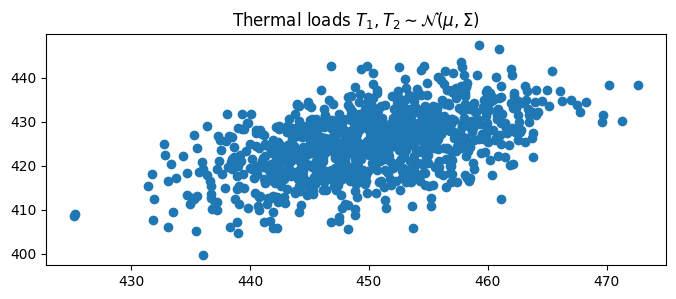

In [17]:
from mvm import GaussianFunc, UniformFunc
import numpy as np

# T1,T2 distribution (Gaussian)
center = np.array([450, 425])
Sigma = np.array([
    [50, 12.5],
    [37.5, 50],
])
Requirement = GaussianFunc(center, Sigma, 'temp')

Requirement.random(1000)
Requirement.view(xlabel='Thermal loads $T_1,T_2 \
    \sim \mathcal{N}(\mu,\Sigma)$')
Requirement.reset()

We define the random input specifications as follows by supplying the arguments ``cov_index`` and ``distribution``

In [18]:
from mvm import InputSpec

# define input specifications
s1 = InputSpec(center[0], 'S1', universe=[325, 550], variable_type='FLOAT', cov_index=0,
               description='nacelle temperature', distribution=Requirement,
               symbol='T1', inc=-1e-0, inc_type='rel')
s2 = InputSpec(center[1], 'S2', universe=[325, 550], variable_type='FLOAT', cov_index=1,
               description='gas surface temperature', distribution=Requirement,
               symbol='T2', inc=+1e-0, inc_type='rel')
input_specs = [s1, s2]

Instead of redifining the MAN from scratch, we can subclass the original deterministic ``MAN`` and extend it by defining the ``randomize`` method to allow the MAN to draw random samples on input specs $T_1$ and $T_2$. The new stochastic version of the previous MAN is defined by ``StoMAN``

In [19]:
# Define the stochastic MAN
class StoMAN(MAN):

    def randomize(self):
        s1 = self.input_specs[0]
        s2 = self.input_specs[1]
        s1.random()
        s2.random()

sto_man = StoMAN(design_params,input_specs,fixed_params,
    behaviours,decisions,margin_nodes,performances,'MAN_2')


We use a Monte-Carlo simulation to obtain the distribution of impact and absorption in the design

In [20]:
import sys

# Perform Monte-Carlo simulation
n_epochs = 1000
for n in range(n_epochs):
    
    sys.stdout.write("Progress: %d%%   \r" %((n/n_epochs)* 100)) # display progress
    sys.stdout.flush()

    sto_man.randomize()
    sto_man.init_decisions()
    sto_man.allocate_margins()
    sto_man.forward()
    sto_man.compute_impact()
    sto_man.compute_absorption()

We view the distribution of excess

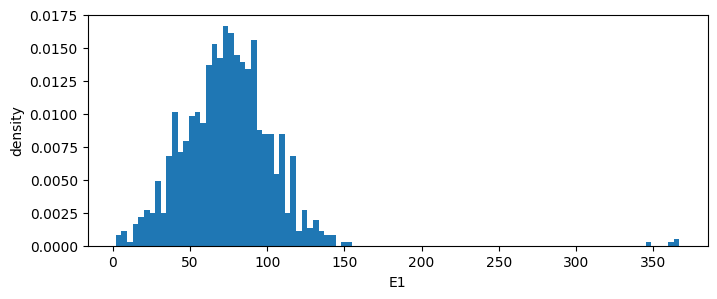

In [21]:
# View distribution of excess
sto_man.margin_nodes[0].excess.view()

we view the distribution of impact on performance

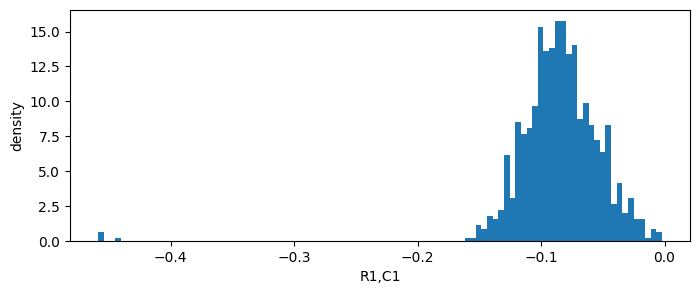

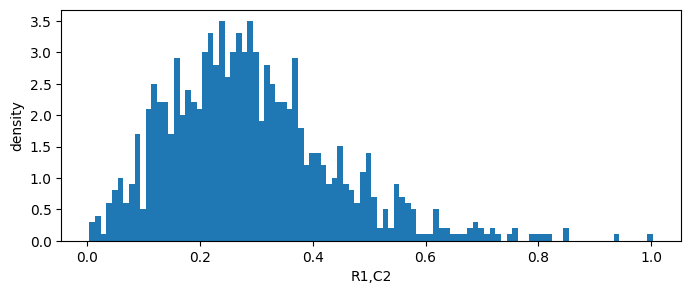

In [22]:
# View distribution of Impact on Performance
sto_man.impact_matrix.view(0,0)
sto_man.impact_matrix.view(0,1)

We view the distribution of change absorption capability of margin node 1

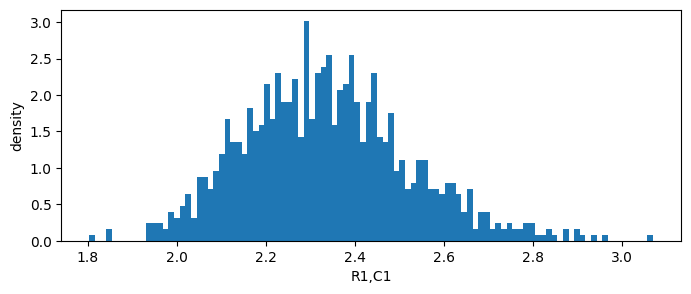

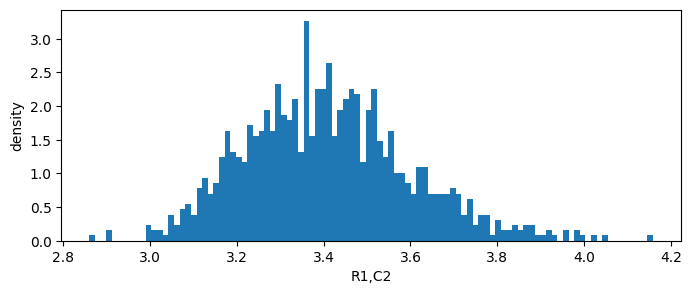

In [23]:
sto_man.absorption_matrix.view(0,0)
sto_man.absorption_matrix.view(0,1)

Finally, we view the margin value plot

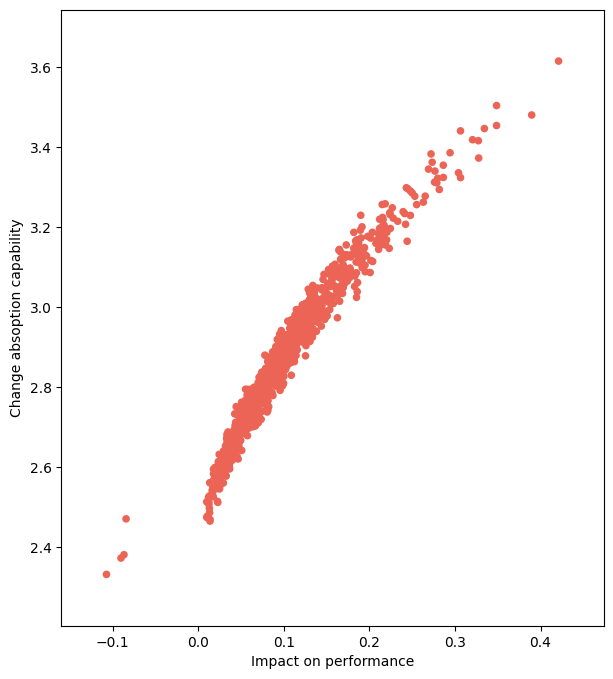

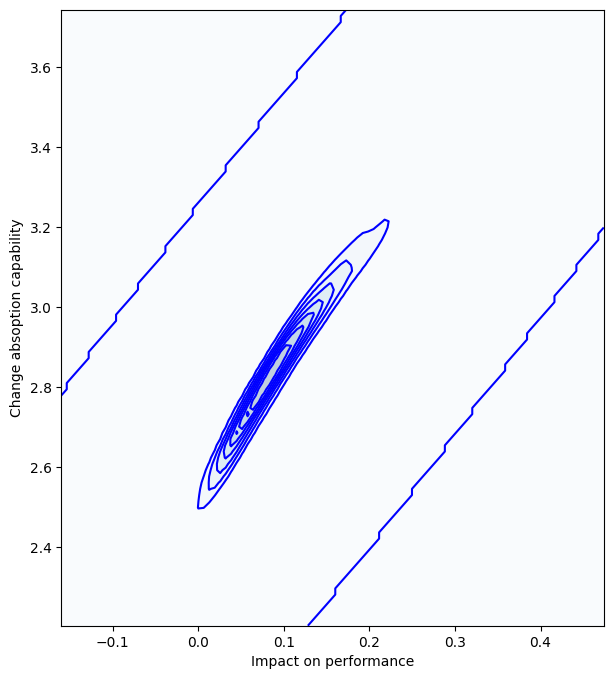

0.011306362998459859

In [24]:
# display the margin value plot
sto_man.compute_mvp('scatter')
sto_man.compute_mvp('density')

## The effect of design parameters on change absorption and impact on performance

Let us look at an alternative design given by different values of $w$, $h$, and $\theta$

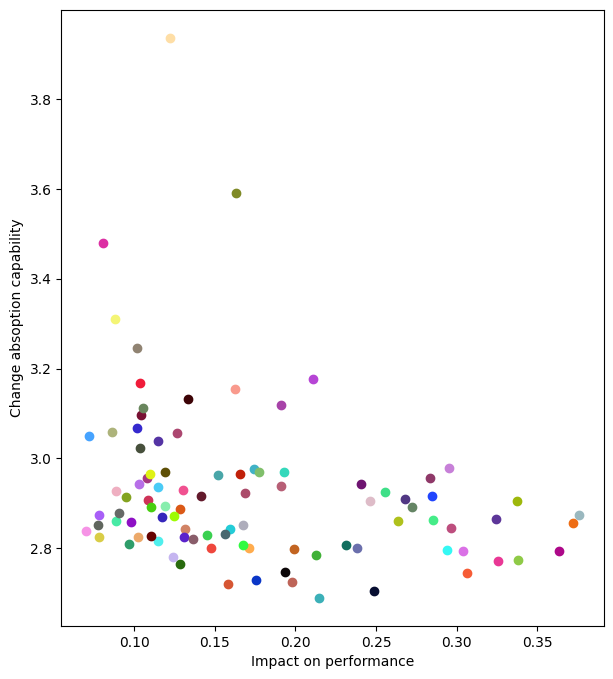

In [25]:
from mvm import Design
import matplotlib.pyplot as plt

# Effect of alternative designs
n_designs = 100
n_epochs = 10
lb = np.array(man.universe_d)[:, 0]
ub = np.array(man.universe_d)[:, 1]
design_doe = Design(lb, ub, n_designs, 'LHS')

# create empty figure
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Impact on performance')
ax.set_ylabel('Change absoption capability')

X = np.empty((1,len(man.margin_nodes)))
Y = np.empty((1,len(man.margin_nodes)))
D = np.empty((1,len(man.design_params)))

for d,design in enumerate(design_doe.unscale()):
    sto_man.nominal_design_vector = design
    sto_man.reset()
    sto_man.reset_outputs()

    # Perform Monte-Carlo simulation
    for n in range(n_epochs):
        
        sys.stdout.write("Progress: %d%%   \r" % ((d * n_epochs + n) / (n_designs * n_epochs) * 100))
        sys.stdout.flush()

        sto_man.randomize()
        sto_man.init_decisions()
        sto_man.allocate_margins()
        sto_man.forward()
        sto_man.compute_impact()
        sto_man.compute_absorption()
    
    # Extract x and y
    x = np.mean(sto_man.impact_matrix.values,axis=(1,2)).ravel() # average along performance parameters (assumes equal weighting)
    y = np.mean(sto_man.absorption_matrix.values,axis=(1,2)).ravel() # average along input specs (assumes equal weighting)

    if not all(np.isnan(y)):
        X = np.vstack((X,x))
        Y = np.vstack((Y,y))
        D = np.vstack((D,design))

    # plot the results
    color = np.random.random((1,3))
    ax.scatter(x,y,c=color)

plt.show()

Now we calculate the distance to the neutral line to rank different designs

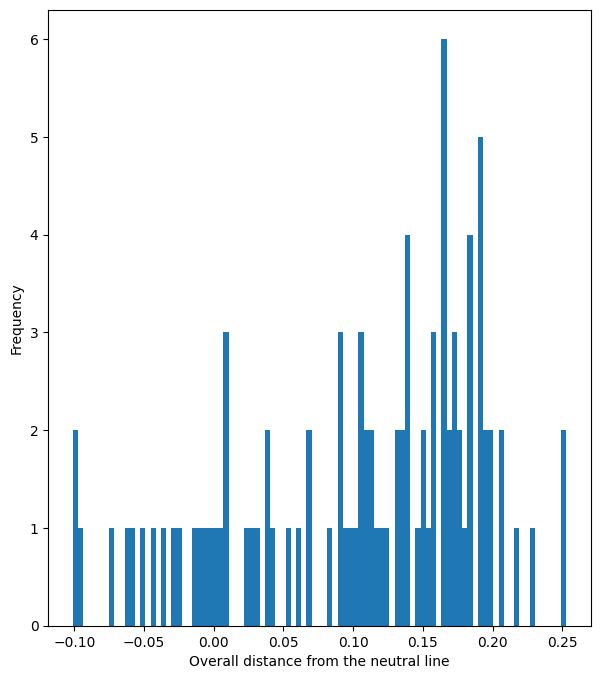

---------------------------------
The best design:
w = 85.258
h = 15.242
theta = 3.865
---------------------------------


In [26]:
from mvm import nearest

# Calculate distance metric
p1 = np.array([X.min(),Y.min()])
p2 = np.array([X.max(),Y.max()])
p1 = p1 - 0.1*abs(p2 - p1)
p2 = p2 + 0.1*abs(p2 - p1)

distances = np.empty(0)
for i,(x,y) in enumerate(zip(X,Y)):

    dist = 0
    for node in range(len(x)):
        s = np.array([x[node],y[node]])
        pn,d = nearest(p1,p2,s)
        dist += d

    distances = np.append(distances,dist)

# create empty figure
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Overall distance from the neutral line')
ax.set_ylabel('Frequency')
ax.hist(distances,bins=len(distances))

plt.show()

best_i = np.argmax(distances)
best_design = D[best_i,:]

print('---------------------------------')
result = 'The best design:\n'
for value,d_object in zip(best_design,sto_man.design_params):
    result += d_object.symbol + ' = ' + '%.3f'%value + '\n'

result += '---------------------------------'
print(result)


Let us visualize the distance calculation for three different designs

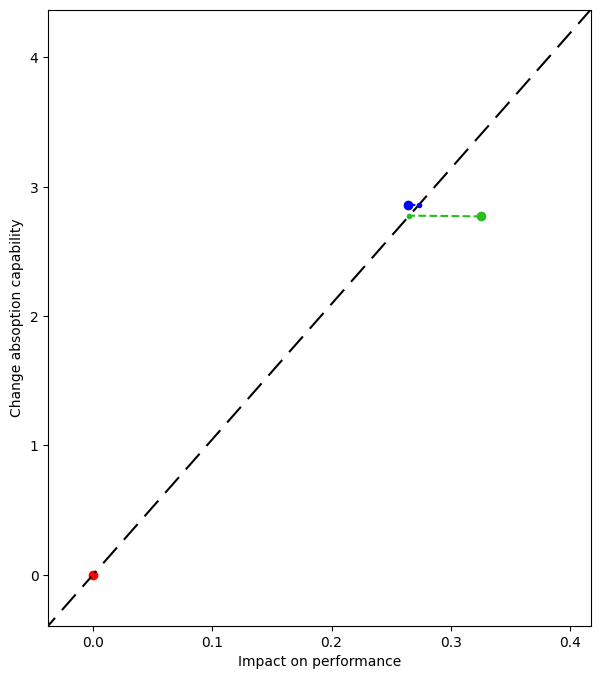

In [27]:

# display distances only for three designs
X_plot = X[0:3,:]
Y_plot = Y[0:3,:]

# create empty figure
colors = ['#FF0000','#27BE1E','#0000FF']
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Impact on performance')
ax.set_ylabel('Change absoption capability')
ax.set_xlim(p1[0],p2[0])
ax.set_ylim(p1[1],p2[1])

p = ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k',linestyle=(5,(10,5)))

distances = np.empty(0)
for i,(x,y) in enumerate(zip(X_plot,Y_plot)):

    ax.scatter(x,y,c=colors[i])

    dist = 0
    for node in range(len(x)):
        s = np.array([x[node],y[node]])
        pn,d = nearest(p1,p2,s)
        dist += d

        x_d = [s[0],pn[0]]
        y_d = [s[1],pn[1]]
        ax.plot(x_d,y_d,marker='.',linestyle='--',color=colors[i])

    distances = np.append(distances,dist)

plt.show()